In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import seaborn as sns
import librosa
%matplotlib inline

In [2]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import Session

config = ConfigProto()
config.gpu_options.allow_growth = True
sess = Session(config=config)

if tf.test.gpu_device_name():
    print("GPU found")
else:
    print("No GPU found")

GPU found


## Look at the Test Set

In [3]:
dict_genres = {'Electronic':0, 'Experimental':1, 'Folk':2, 'Hip-Hop':3, 'Instrumental':4,'International':5, 'Pop' :6, 'Rock': 7}

In [4]:
# Tree_1
model_root = load_model('models/tree_1/model_finals/model_root.h5')
model_root_f1 = load_model('models/tree_1/model_finals/model_root_f1.h5')
model_root_f1_1 = load_model('models/tree_1/model_finals/model_root_f1_1.h5')
model_root_f1_2 = load_model('models/tree_1/model_finals/model_root_f1_2.h5')
model_root_f2 = load_model('models/tree_1/model_finals/model_root_f2.h5')
model_root_f2_1 = load_model('models/tree_1/model_finals/model_root_f2_1.h5')
model_root_f2_2 = load_model('models/tree_1/model_finals/model_root_f2_2.h5')

In [4]:
# Tree_2
model_root = load_model('models/tree_2/model_finals/model_root.h5')
model_root_f1 = load_model('models/tree_2/model_finals/model_root_f1.h5')
model_root_f1_1 = load_model('models/tree_2/model_finals/model_root_f1_1.h5')
model_root_f1_1_1 = load_model('models/tree_2/model_finals/model_root_f1_1_1.h5')
model_root_f1_1_1_1 = load_model('models/tree_2/model_finals/model_root_f1_1_1_1.h5')
model_root_f1_1_1_1_1 = load_model('models/tree_2/model_finals/model_root_f1_1_1_1_1.h5')
model_root_f1_1_1_1_1_1 = load_model('models/tree_2/model_finals/model_root_f1_1_1_1_1_1.h5')

In [4]:
# Tree_3
model_root = load_model('models/tree_3/model_finals/model_root.h5')
model_root_f1 = load_model('models/tree_3/model_finals/model_root_f1.h5')
model_root_f1_1 = load_model('models/tree_3/model_finals/model_root_f1_1.h5')
model_root_f1_1_1 = load_model('models/tree_3/model_finals/model_root_f1_1_1.h5')

In [5]:
npzfile = np.load('data/test_arr.npz')
print(npzfile.files)

X_test = npzfile['arr_0']
y_test = npzfile['arr_1']
print(X_test.shape, y_test.shape)

['arr_0', 'arr_1']
(800, 640, 128) (800,)


In [6]:
y_test -= 1
print(np.amin(y_test), np.amax(y_test), np.mean(y_test))

0 7 3.5


In [7]:
y_true = y_test
#y_true = y_true[np.in1d(y_true, [1,5])]
#y_true_binary = np.invert(np.in1d(y_true, [1,5]))*1

In [8]:
X_test_raw = librosa.core.db_to_power(X_test, ref=1.0)
X_test = np.log(X_test_raw)

print(np.amin(X_test_raw), np.amax(X_test_raw), np.mean(X_test_raw))

1e-08 1.0000008783668917 0.0046238130656683


In [9]:
X_test = np.expand_dims(X_test, axis = -1)

In [10]:
print(X_test.shape, y_test.shape, y_true.shape)

(800, 640, 128, 1) (800,) (800,)


In [11]:
class ModelNodeTree():
    def __init__(self, model, left, right, translate = None):
        self._model = model
        self._left = left
        self._right = right
        self._translate = translate
        
    def predict(self, batch):
        y = self._model.predict(batch)
        y = np.argmax(y, axis=1)
        
        if self._translate is not None:
            for k, t in self._translate.items():
                y[y == t] = k
        else:
            if np.sum(y == 0) > 0:
                if type(self._left) == int:
                    y[y == 0] = self._left
                else:
                    y[y == 0] = self._left.predict(batch[y == 0])

            if np.sum(y == 1) > 0:
                if type(self._right) == int:
                    y[y == 1] = self._right
                else:
                    y[y == 1] = self._right.predict(batch[y == 1])
        
        return y

In [12]:
# Test_1
f2_2 = ModelNodeTree(model_root_f2_2, 5, 1)
f2_1 = ModelNodeTree(model_root_f2_1, 0, 3)
f2 = ModelNodeTree(model_root_f2, f2_1, f2_2)

f1_2 = ModelNodeTree(model_root_f1_2, 2, 4)
f1_1 = ModelNodeTree(model_root_f1_1, 6, 7)
f1 = ModelNodeTree(model_root_f1, f1_1, f1_2)

root = ModelNodeTree(model_root, f1, f2)

In [13]:
# Test_2
f1_1_1_1_1_1 = ModelNodeTree(model_root_f1_1_1_1_1_1, 6, 1)
f1_1_1_1_1 = ModelNodeTree(model_root_f1_1_1_1_1, f1_1_1_1_1_1, 0)
f1_1_1_1 = ModelNodeTree(model_root_f1_1_1_1, f1_1_1_1_1, 5)
f1_1_1 = ModelNodeTree(model_root_f1_1_1, f1_1_1_1, 4)
f1_1 = ModelNodeTree(model_root_f1_1, f1_1_1, 7)
f1 = ModelNodeTree(model_root_f1, f1_1, 3)

root = ModelNodeTree(model_root, f1, 2)

In [ ]:
# Test_3
dict_genres_mod = {4:2, 5:3, 6:4}

f1_1_1 = ModelNodeTree(model_root_f1_1_1, None, None, dict_genres_mod)
f1_1 = ModelNodeTree(model_root_f1_1, f1_1_1, 7)
f1 = ModelNodeTree(model_root_f1, f1_1, 3)

root = ModelNodeTree(model_root, f1, 2)

In [13]:
y_pred = root.predict(X_test)

In [14]:
#X_test = X_test[np.in1d(y_test, [1,5])]
#y_pred = np.argmax(model_root.predict(X_test), axis=1)

In [15]:
labels = ["0","1"]
target_names = dict_genres.keys()

print(y_true.shape, y_pred.shape)
print(classification_report(y_true, y_pred, target_names=target_names))

(800,) (800,)
               precision    recall  f1-score   support

   Electronic       0.50      0.43      0.46       100
 Experimental       0.33      0.27      0.30       100
         Folk       0.24      0.24      0.24       100
      Hip-Hop       0.65      0.81      0.72       100
 Instrumental       0.47      0.33      0.39       100
International       0.31      0.32      0.31       100
          Pop       0.27      0.39      0.32       100
         Rock       0.62      0.54      0.58       100

     accuracy                           0.42       800
    macro avg       0.42      0.42      0.41       800
 weighted avg       0.42      0.42      0.41       800



Text(91.68, 0.5, 'predicted label')

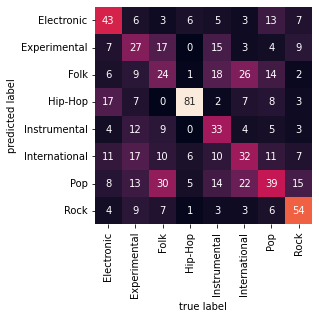

In [16]:
labels = [0,1]
mat = confusion_matrix(y_true, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, xticklabels=target_names, yticklabels=target_names)
plt.xlabel('true label')
plt.ylabel('predicted label')

In [17]:
print(accuracy_score(y_true, y_pred))

0.35875


#### TEST

In [42]:
i=0

print(list(dict_genres.keys())[list(dict_genres.values()).index(y_true[i])])

y_pred_single = root.predict(np.array([X_test[i]]))
print(list(dict_genres.keys())[list(dict_genres.values()).index(y_pred_single[0])])

Rock
Pop


In [ ]:
#dict_genres = {'Electronic':0, 'Experimental':1, 'Folk':2, 'Hip-Hop':3, 'Instrumental':4,'International':5, 'Pop' :6, 'Rock': 7}
i = 10
y_test[i]

In [ ]:
model_root.predict(np.array([X_test[i]]))